In [23]:
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
#Not using StandardScaler as it normalises values around 0, hence they can be negative as well
from sklearn.ensemble import IsolationForest
import joblib
from sklearn.model_selection import GridSearchCV

In [18]:
def preprocess_data(data_frame):
    #Handle missing values
    data_frame["Money_Value"].fillna(data_frame["Money_Value"].median(), inplace = True)
    
    feature_mapping = {
        'PARA_A' : "Transaction_Amount",
        'PARA_B' : "Vendor_Trust_Score",
        'SCORE_A' : 'Transaction_Amount_Score',
        'SCORE_B': 'Vendor_Trust_Score_Rating'
    }

    data_frame.rename(columns = feature_mapping, inplace = True)

    #Feature Engineering
    data_frame['Transaction_Frequency'] = data_frame.groupby('LOCATION_ID')['TOTAL'].transform('count')
    data_frame['New_Vendor_Flag'] = (data_frame['History'] < 30).astype(int)
    data_frame['Recent_Account_Change_Flag'] = (data_frame['History'] < 60).astype(int)
    data_frame['High_Value_Flag'] = (data_frame['TOTAL'] > 10000).astype(int)
    data_frame['Approval_Anomaly_Flag'] = (data_frame['District'] > 4).astype(int)
    data_frame['Risk_Score_Adjusted'] = (0.4 * data_frame['TOTAL'] + 0.3 * data_frame['Money_Value'] + 0.3 * data_frame['Loss'])

    # Normalize Numerical Features
    numeric_cols = ['TOTAL', 'Money_Value', 'Transaction_Frequency', 'Risk_Score_Adjusted']
    scaler = MinMaxScaler()
    data_frame[numeric_cols] = scaler.fit_transform(data_frame[numeric_cols])

    return data_frame

In [19]:
data_frame = pd.read_csv("trial.csv")
preprocessed_data_frame = preprocess_data(data_frame)

/var/folders/0m/l397lmq961z3h8417zx843y80000gp/T/ipykernel_29019/2730930653.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data_frame["Money_Value"].fillna(data_frame["Money_Value"].median(), inplace = True)


In [20]:
preprocessed_data_frame

,Sector_score,LOCATION_ID,Transaction_Amount,Transaction_Amount_Score,Vendor_Trust_Score,Vendor_Trust_Score_Rating,TOTAL,numbers,Marks,Money_Value,...,History,History_score,Score,Risk,Transaction_Frequency,New_Vendor_Flag,Recent_Account_Change_Flag,High_Value_Flag,Approval_Anomaly_Flag,Risk_Score_Adjusted
0,3.89,23,4.18,6,2.50,2,0.005264,5.0,2,0.003615,...,0,2,2.4,1,0.000000,1,1,0,0,0.007018
1,3.89,6,0.00,2,4.83,2,0.003806,5.0,2,0.001005,...,0,2,2.0,0,0.426667,1,1,0,0,0.004215
2,3.89,6,0.51,2,0.23,2,0.000583,5.0,2,0.000000,...,0,2,2.0,0,0.426667,1,1,0,0,0.000564
3,3.89,6,0.00,2,10.80,6,0.008511,6.0,6,0.012566,...,0,2,4.4,1,0.426667,1,1,0,0,0.014937
4,3.89,6,0.00,2,0.08,2,0.000063,5.0,2,0.000000,...,0,2,2.0,0,0.426667,1,1,0,0,0.000061
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,55.57,9,0.49,2,0.40,2,0.000701,5.0,2,0.000000,...,0,2,2.0,0,0.693333,1,1,0,0,0.000678
772,55.57,16,0.47,2,0.37,2,0.000662,5.0,2,0.000000,...,0,2,2.0,0,0.680000,1,1,0,0,0.000640
773,55.57,14,0.24,2,0.04,2,0.000221,5.0,2,0.000000,...,0,2,2.0,0,0.253333,1,1,0,0,0.000213
774,55.57,18,0.20,2,0.00,2,0.000158,5.0,2,0.000000,...,0,2,2.0,0,0.200000,1,1,0,0,0.000152


In [40]:
def train_isolation_forest(data_frame):
    # Select features for training
    features = ['TOTAL', 'Money_Value', 'Transaction_Frequency', 'Risk_Score_Adjusted',
                'New_Vendor_Flag', 'Recent_Account_Change_Flag', 'High_Value_Flag', 'Approval_Anomaly_Flag']

    # Parameter grid for fine-tuning
    param_grid = {
        'n_estimators': [100, 200, 300],
        'contamination': [0.01, 0.05, 0.1],
        'max_features': [0.5, 0.75, 1.0]
    }

    model = IsolationForest(random_state=42)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(data_frame[features], data_frame['Risk'])

    best_model = grid_search.best_estimator_
    data_frame['Raw_Anomaly_Score'] = best_model.decision_function(data_frame[features])

    # Scale Raw Anomaly Scores into 0-100 Risk Score Range
    data_frame['Risk_Score'] = MinMaxScaler(feature_range=(0, 100)).fit_transform(data_frame[['Raw_Anomaly_Score']])

    # Save model for future use
    joblib.dump(best_model, "isolation_forest_model.pkl")

    return data_frame

In [41]:
trained_model_data_frame = train_isolation_forest(preprocessed_data_frame)

In [42]:
trained_model_data_frame

,Sector_score,LOCATION_ID,Transaction_Amount,Transaction_Amount_Score,Vendor_Trust_Score,Vendor_Trust_Score_Rating,TOTAL,numbers,Marks,Money_Value,...,Score,Risk,Transaction_Frequency,New_Vendor_Flag,Recent_Account_Change_Flag,High_Value_Flag,Approval_Anomaly_Flag,Risk_Score_Adjusted,Risk_Score,Raw_Anomaly_Score
0,3.89,23,4.18,6,2.50,2,0.005264,5.0,2,0.003615,...,2.4,1,0.000000,1,1,0,0,0.007018,69.697195,0.203408
1,3.89,6,0.00,2,4.83,2,0.003806,5.0,2,0.001005,...,2.0,0,0.426667,1,1,0,0,0.004215,92.836673,0.307134
2,3.89,6,0.51,2,0.23,2,0.000583,5.0,2,0.000000,...,2.0,0,0.426667,1,1,0,0,0.000564,99.486018,0.336941
3,3.89,6,0.00,2,10.80,6,0.008511,6.0,6,0.012566,...,4.4,1,0.426667,1,1,0,0,0.014937,82.840270,0.262324
4,3.89,6,0.00,2,0.08,2,0.000063,5.0,2,0.000000,...,2.0,0,0.426667,1,1,0,0,0.000061,98.905231,0.334337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,55.57,9,0.49,2,0.40,2,0.000701,5.0,2,0.000000,...,2.0,0,0.693333,1,1,0,0,0.000678,99.063887,0.335048
772,55.57,16,0.47,2,0.37,2,0.000662,5.0,2,0.000000,...,2.0,0,0.680000,1,1,0,0,0.000640,99.662575,0.337732
773,55.57,14,0.24,2,0.04,2,0.000221,5.0,2,0.000000,...,2.0,0,0.253333,1,1,0,0,0.000213,95.803960,0.320435
774,55.57,18,0.20,2,0.00,2,0.000158,5.0,2,0.000000,...,2.0,0,0.200000,1,1,0,0,0.000152,94.310405,0.313740


In [43]:
trained_model_data_frame["Risk_Score"].describe

<bound method NDFrame.describe of 0      69.697195
1      92.836673
2      99.486018
3      82.840270
4      98.905231
         ...    
771    99.063887
772    99.662575
773    95.803960
774    94.310405
775    98.375129
Name: Risk_Score, Length: 776, dtype: float64>

In [48]:
unique_risk_scores = data_frame['Risk_Score'].unique().tolist()
print("Unique Risk Scores:", sum(unique_risk_scores)/len(unique_risk_scores))

Unique Risk Scores: 80.63976809261206


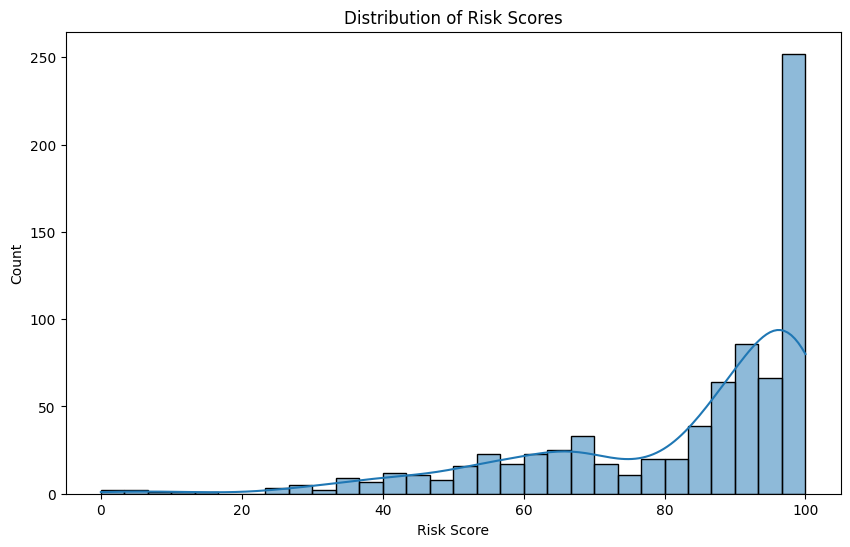

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(trained_model_data_frame['Risk_Score'], bins=30, kde=True)
plt.title('Distribution of Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.show()

In [51]:
high_risk_count = (trained_model_data_frame['Risk_Score'] > 70).sum()
total_count = len(trained_model_data_frame)
print(f"High-risk transactions (> 70): {high_risk_count} / {total_count} ({(high_risk_count/total_count)*100:.2f}%)")

very_high_risk_count = (trained_model_data_frame['Risk_Score'] > 90).sum()
print(f"Very High-risk transactions (> 90): {very_high_risk_count} / {total_count} ({(very_high_risk_count/total_count)*100:.2f}%)")

High-risk transactions (> 70): 575 / 776 (74.10%)
Very High-risk transactions (> 90): 404 / 776 (52.06%)


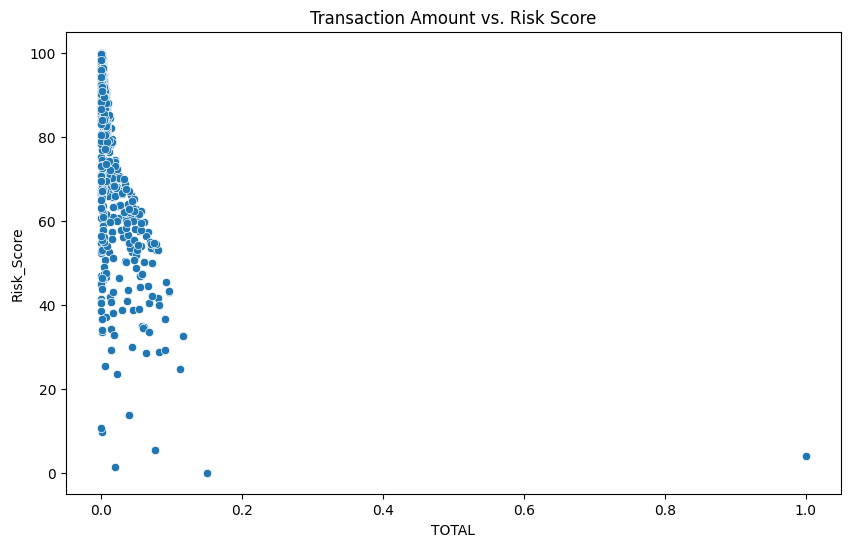

In [53]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TOTAL', y='Risk_Score', data=trained_model_data_frame)
plt.title('Transaction Amount vs. Risk Score')
plt.show()